# Wildlife Species Identification on Camera Trap Images
> * 🔬 Data Science
* 🥠 Deep Learning and Image Classification

## Table of Contents
* [Introduction](#Introduction)
* [Necessary imports](#Necessary-imports)
* [Connect to your GIS](#Connect-to-your-GIS)
* [Get the data for analysis](#Get-the-data-for-analysis)
 * [Data selection](#Data-selection)
 * [Prepare data](#Prepare-data)
 * [Visualize a few samples from your training data](#Visualize-a-few-samples-from-your-training-data)
* [Train the model](#Train-the-model)
 * [Load model architecture](#Load-model-architecture)
 * [Find an optimal learning rate](#Find-an-optimal-learning-rate)
 * [Fit the model](#Fit-the-model)
 * [Visualize results in validation set](#Visualize-results-in-validation-set)
 * [Save the model](#Save-the-model)
* [Model Inferencing](#Model-inferencing)
 * [Data preparation](#Data-preparation)
 * [Inferencing](#Inferencing) 
* [Conclusion](#Conclusion)

## Introduction 

This notebook intends to showcase the workflow to classify animal species on camera trap images. This notebook has two main sections:
1. Training a deep learning model that can classify animal species  
2. Using the trained model to classify animal species against each camera location

We have used a subset of a community licensed open source dataset for camera trap images provided under [LILA BC](http://lila.science/) (Labeled Information Library of Alexandria: Biology and Conservation) repository to train our deep learning model details of which are shared in [this](#Get-the-data-for-analysis) section. For inferencing, we have taken 5 fictional camera locations in Kruger National Park, South Africa and to each of those points we have some images attached as attachments. This feature layer simulates a requirement where there are multiple cameras at different locations and images captured by each of those cameras need to be classified for animal species. The whole workflow enabling this required in explained in [this](#) section. 

## Necessary imports 

In [1]:
import os
import json
import pandas as pd
from fastai.vision import *

from arcgis.gis import GIS
from arcgis.learn import prepare_data, FeatureClassifier, classify_objects, Model

## Connect to your GIS 

In [2]:
# connect to web GIS
gis = GIS("https://pythonapi.playground.esri.com/portal", "arcgis_python","amazing_arcgis_123")

## Get the data for analysis

In this notebook, we have used "WCS Camera Traps" dataset made publicly available by [Wildlife Conservation Society](https://www.wcs.org/) under [LILA BC repository](http://lila.science/). This data set contains approximately 1.4M camera trap images representing different species from 12 countries, making it one of the most diverse camera trap data sets available publicly. The dataset can be explored and downloaded from [this link](http://lila.science/datasets/wcscameratraps). This data set is released under the [Community Data License Agreement (permissive variant)](https://cdla.io/permissive-1-0/).

### Data selection

This dataset has 1.4M images related to 675 different species out of which we have chosen 11 species whose conservation status was either "Endangered", "Near Threatened" or "Vulnerable". These species include Jaguars, African elephants, Lions, Thomson's gazelles, East African oryxs, Gerenuks, Asian elephants, Tigers, Ocellated turkeys and Great curassows. 

The json file (wcs_camera_traps.json) that comes with the data contains metadata we require.

In [3]:
with open('wcs_camera_traps.json') as f:
    metadata = json.load(f)

Loading the annotations and images in a dataframe from the json file.

In [4]:
annotation_df = pd.DataFrame(metadata['annotations'])
images_df = pd.DataFrame(metadata['images'])

Merging both annotations and images dataframes into a single dataframe.

In [5]:
img_ann_df = pd.merge(images_df, annotation_df, left_on='id', right_on='image_id', how='left').drop('image_id', axis=1)
img_ann_df

id_x                          wcs_id  \
0        c6fe0cba-92d4-11e9-ac1e-000d3a74c7de           bol-001-d0005-i000010   
1        c6fea8fa-92d4-11e9-a58a-000d3a74c7de           bol-001-d0005-i000011   
2        c6fea8fc-92d4-11e9-8c7a-000d3a74c7de           bol-001-d0005-i000012   
3        c6fed00c-92d4-11e9-97a0-000d3a74c7de           bol-001-d0005-i000013   
4        c6fed00e-92d4-11e9-97d9-000d3a74c7de           bol-001-d0005-i000014   
...                                       ...                             ...   
1369986  c2dc4e70-92d5-11e9-a55d-000d3a74c7de           rwa-005-d0001-i006887   
1369987  c2dc7540-92d5-11e9-9806-000d3a74c7de           rwa-005-d0001-i006888   
1369988  c2dc7542-92d5-11e9-895e-000d3a74c7de           rwa-005-d0001-i006889   
1369989  c2dc7544-92d5-11e9-8830-000d3a74c7de           rwa-005-d0001-i006890   
1369990  c2dc9c80-92d5-11e9-afba-000d3a74c7de  team-001-bif-2-08-2011-i060630   

                     file_name  frame_num           seq_id country_code  \
0        animals/0000/0000.jpg          6  bol-001-d0005-3          bol   
1        animals/0000/0001.jpg          7  bol-001-d0005-3          bol   
2        animals/0000/0002.jpg          8  bol-001-d0005-3          bol   
3        animals/0000/0003.jpg          9  bol-001-d0005-3          bol   
4        animals/0000/0004.jpg         10  bol-001-d0005-3          bol   
...                        ...        ...              ...          ...   
1369986   humans/0684/1986.jpg         -1          unknown          rwa   
1369987   humans/0684/1987.jpg         -1          unknown          rwa   
1369988   humans/0684/1988.jpg         -1          unknown          rwa   
1369989   humans/0684/1989.jpg         -1          unknown          rwa   
1369990  animals/0684/1990.jpg         -1          unknown          uga   

         match_level                 datetime location  width  height  \
0                  0  2001-02-28 00:00:00.000        0    819     542   
1                  0  2001-02-28 00:00:00.000        0    819     542   
2                  0  2001-02-28 00:00:00.000        0    819     542   
3                  0  2001-02-28 00:00:00.000        0    819     542   
4                  0  2001-02-28 00:00:00.000        0    819     542   
...              ...                      ...      ...    ...     ...   
1369986            1  2015-07-14 06:45:43.000     4731   2048    1536   
1369987            1  2015-07-14 06:45:44.000     4731   2048    1536   
1369988            1  2015-07-14 06:45:45.000     4731   2048    1536   
1369989            1  2015-07-14 06:45:46.000     4731   2048    1536   
1369990            0  2011-07-03 10:17:00.000     6067   2048    1536   

         corrupt  seq_num_frames status  count      sex      age  \
0          False              32             1  unknown  unknown   
1          False              32             1  unknown  unknown   
2          False              32             1  unknown  unknown   
3          False              32             1  unknown  unknown   
4          False              32             1  unknown  unknown   
...          ...             ...    ...    ...      ...      ...   
1369986    False              -1            -1  unknown  unknown   
1369987    False              -1            -1  unknown  unknown   
1369988    False              -1            -1  unknown  unknown   
1369989    False              -1            -1  unknown  unknown   
1369990    False              -1             1  unknown  unknown   

                                         id_y  category_id  
0        c6fe0cbb-92d4-11e9-bd44-000d3a74c7de            1  
1        c6fea8fb-92d4-11e9-911e-000d3a74c7de            1  
2        c6fea8fd-92d4-11e9-8b58-000d3a74c7de            1  
3        c6fed00d-92d4-11e9-918b-000d3a74c7de            1  
4        c6fed00f-92d4-11e9-9f46-000d3a74c7de            1  
...                                       ...          ...  
1369986  c2dc4e71-92d5-11e9-bbc4-000d3a74c7de 

We are concerned with the 'filename' and 'category_id', so selecting only these two columns from the merged dataframe.

In [6]:
img_ann_df = img_ann_df[['file_name','category_id']]

In [7]:
img_ann_df.to_csv('train_data.csv')

In [8]:
train_df = pd.read_csv('../train_data.csv')
train_df = train_df.drop(['Unnamed: 0'],axis=1)

There are a few corrupted files in the data which needs a deletion in order to run our model successfully. 

In [9]:
corrupted_files=['/animals/0028/0917.avi','animals/0028/0947.avi','animals/0028/0965.avi',
                 'animals/0402/0905.jpg','animals/0407/1026.jpg','animals/0464/0880.jpg',
                 'animals/0464/0881.jpg','animals/0464/0882.jpg','animals/0464/0884.jpg',
                 'animals/0464/0888.jpg','animals/0464/0889.jpg','animals/0645/0531.jpg',
                 'animals/0645/0532.jpg','animals/0656/0208.jpg','animals/0009/0215.jpg']

In [10]:
train_df = train_df[~train_df['file_name'].isin(corrupted_files)]

In [ ]:
train_df = train_df[~img_ann_df['file_name'].str.contains("avi")]

Creating a list with species id for the 11 chosen animal species.

In [12]:
retained_specie_list = [7,24,90,100,119,127,128,149,154,372,374]                     # list with selected species ids

'category_id' - 0 belongs to all those images which does not contain any animal. A lot of camera traps will be having no animals in them. If we don't create an empty class, then those images with no animals will be classified as one of the animals which we don't want to happen.

To reduce the class imbalance, we will retain ~50% of those empty images in our training dataset. 

In [13]:
new_train_df = train_df[train_df['category_id']==0].sample(frac=0.5, random_state=42)

In [14]:
new_train_df = new_train_df.append(train_df[train_df['category_id'].isin(retained_specie_list)])

### Prepare data 

Here, we are not using `prepare_data()` function provided by `arcgis.learn` to prepare the data for analysis. We will use 'ImageDataBunch.from_df' method provided by fast.ai to read the necessary information from a dataframe and convert it into 'DataBunch' object which will be used for training. We will use the standard set of transforms for data augmentation and use 20% of our training dataset as validation dataset. Notice that we are also normalizing our inputs. 

In [15]:
tfms = get_transforms()

In [16]:
Path_df=Path('..')
data = ImageDataBunch.from_df(path=Path_df,
                              folder='',
                              df=new_train_df,
                              fn_col=0,
                              label_col=1,
                              valid_pct=0.2,
                              seed=42,
                              bs=256,
                              size=224,
                              num_workers=2).normalize(imagenet_stats)

The number of classes in our dataset can be seen below.

In [17]:
data.c

12

We need to explicitly provide the class mapping to our data and below is the code that let us do that.

In [18]:
class_mapping = {}
index = 1
for class_name in data.classes:
    class_mapping[index] = class_name
    index = index + 1
data.class_mapping = class_mapping

### Visualize a few samples from your training data

While working with a lot of jpeg images, it so happens that some of those images are only available as stream coming from an image and are not complete. Such images might break the process during training. To ensure that training happens on whatever stream is available and that the training flow does not break we set the LOAD_TRUNCATED_IMAGES parameter to True as shown below. 

In [19]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

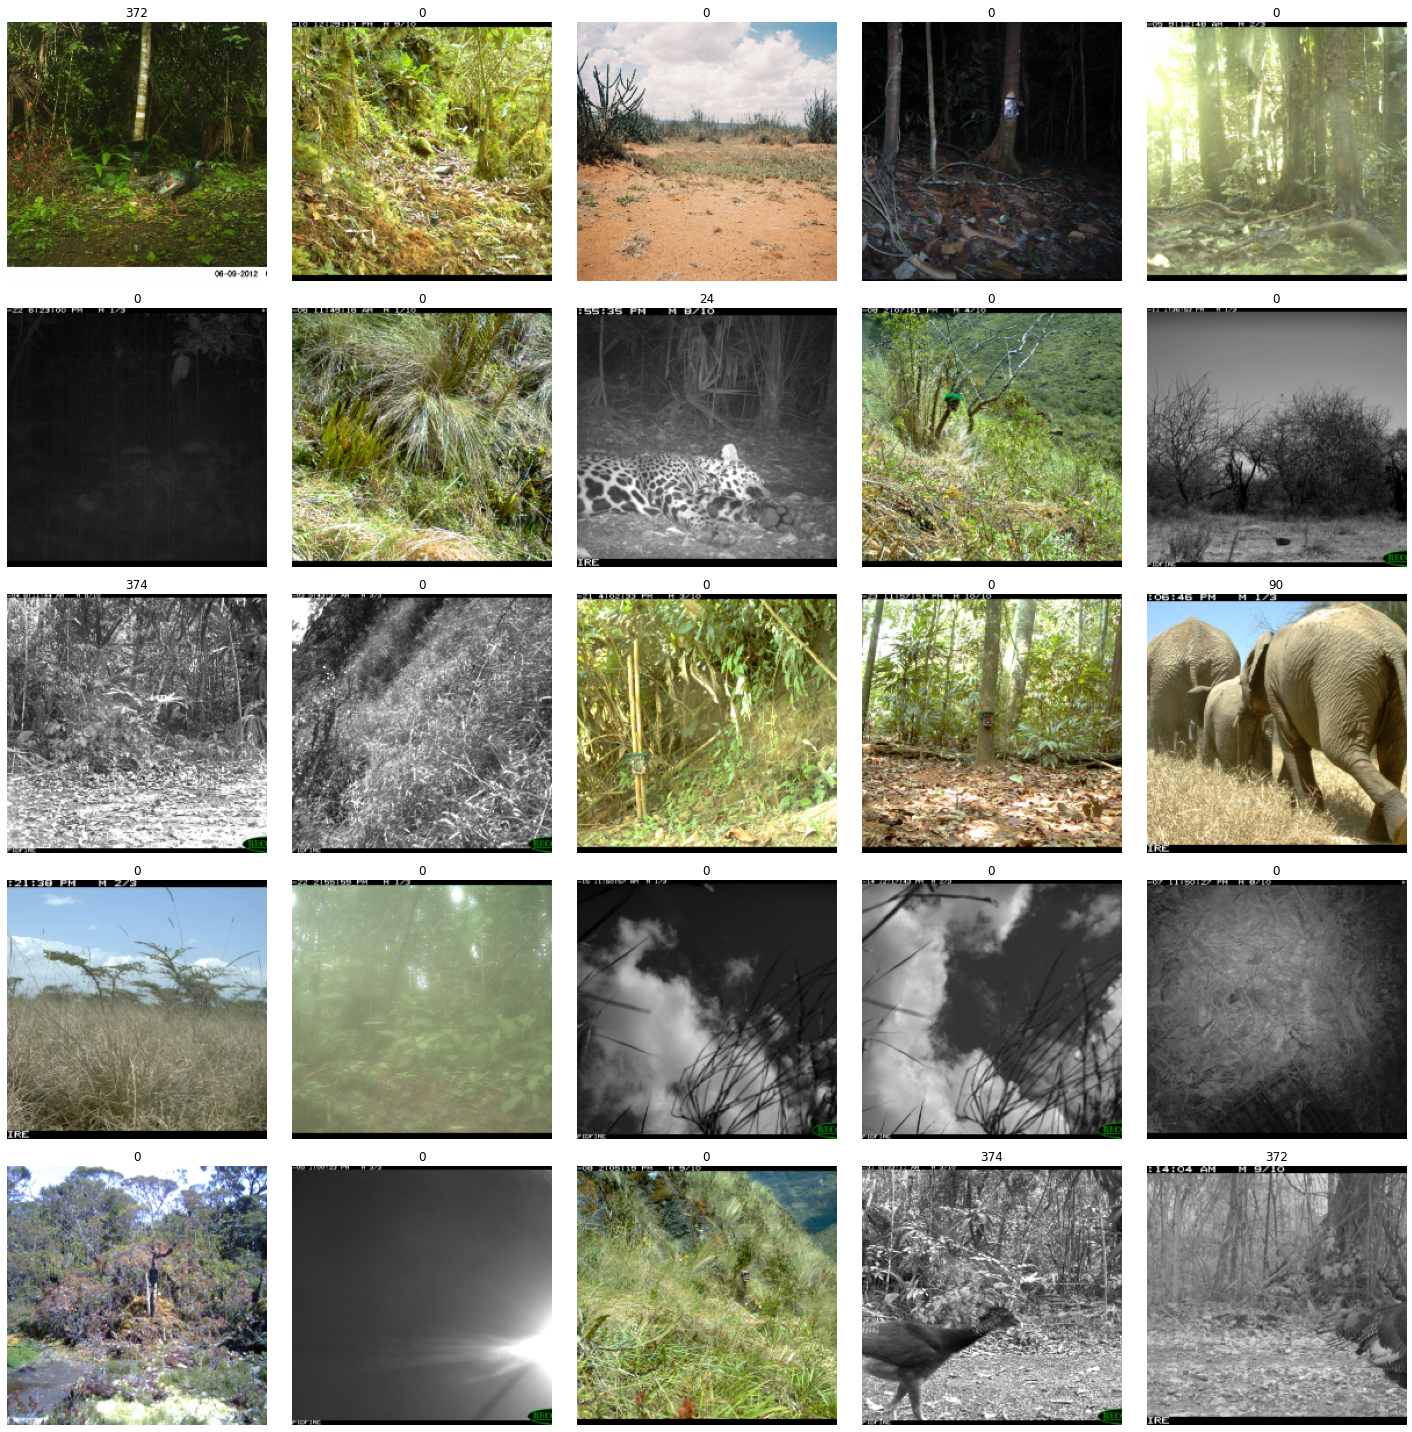

In [20]:
data.show_batch(5)

## Train the model 

### Load model architecture

`arcgis.learn` provides capabilities to determine class of each feature in the form of `FeatureClassifier` model. To have an in-depth information about it's working and usage, have a look at this [link](https://developers.arcgis.com/python/guide/how-feature-categorization-works/). We will use a model with 'ResNet' architecture having 34 layers for our training.

In [21]:
model = FeatureClassifier(data, backbone='resnet34', fpn=False)

### Find an optimal learning rate

Learning rate is one of the most important hyperparameters in model training. Here, we explore a range of learning rates to guide us to choose the best one. `arcgis.learn` leverages fast.ai’s learning rate finder to find an optimum learning rate for training models. We can use the `lr_find()` method to find the optimum learning rate at which can train a robust model fast enough.

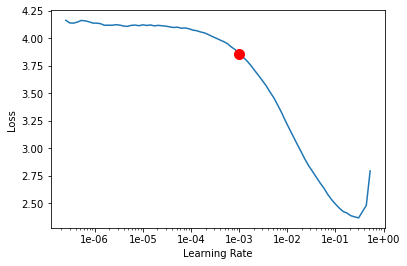

0.001

In [22]:
model.lr_find()

Based on the learning rate plot above, we can see that the learning rate suggested by `lr_find()` for our training data is 0.001. We can use it to train our model. In the latest release of `arcgis.learn` we can train models without even specifying a learning rate. That internally uses the learning rate finder to find an optimal learning rate and uses it.

### Fit the model

To train the model, we use the `fit()` method. To start, we will use 5 epochs to train our model. Epoch defines how many times model is exposed to entire training set.

In [22]:
model.fit(5, 0.001)

### Visualize results in validation set

Notice that after 5 training our model for 5 epochs we are already seeing ~98% accuracy on our validation dataset. We can also visualize those. The code below will pick a few random samples and show us ground truth and respective model predictions side by side. This allows us to validate the results of your model in the notebook itself. Once satisfied, we can save the model and use it further in our workflow. 

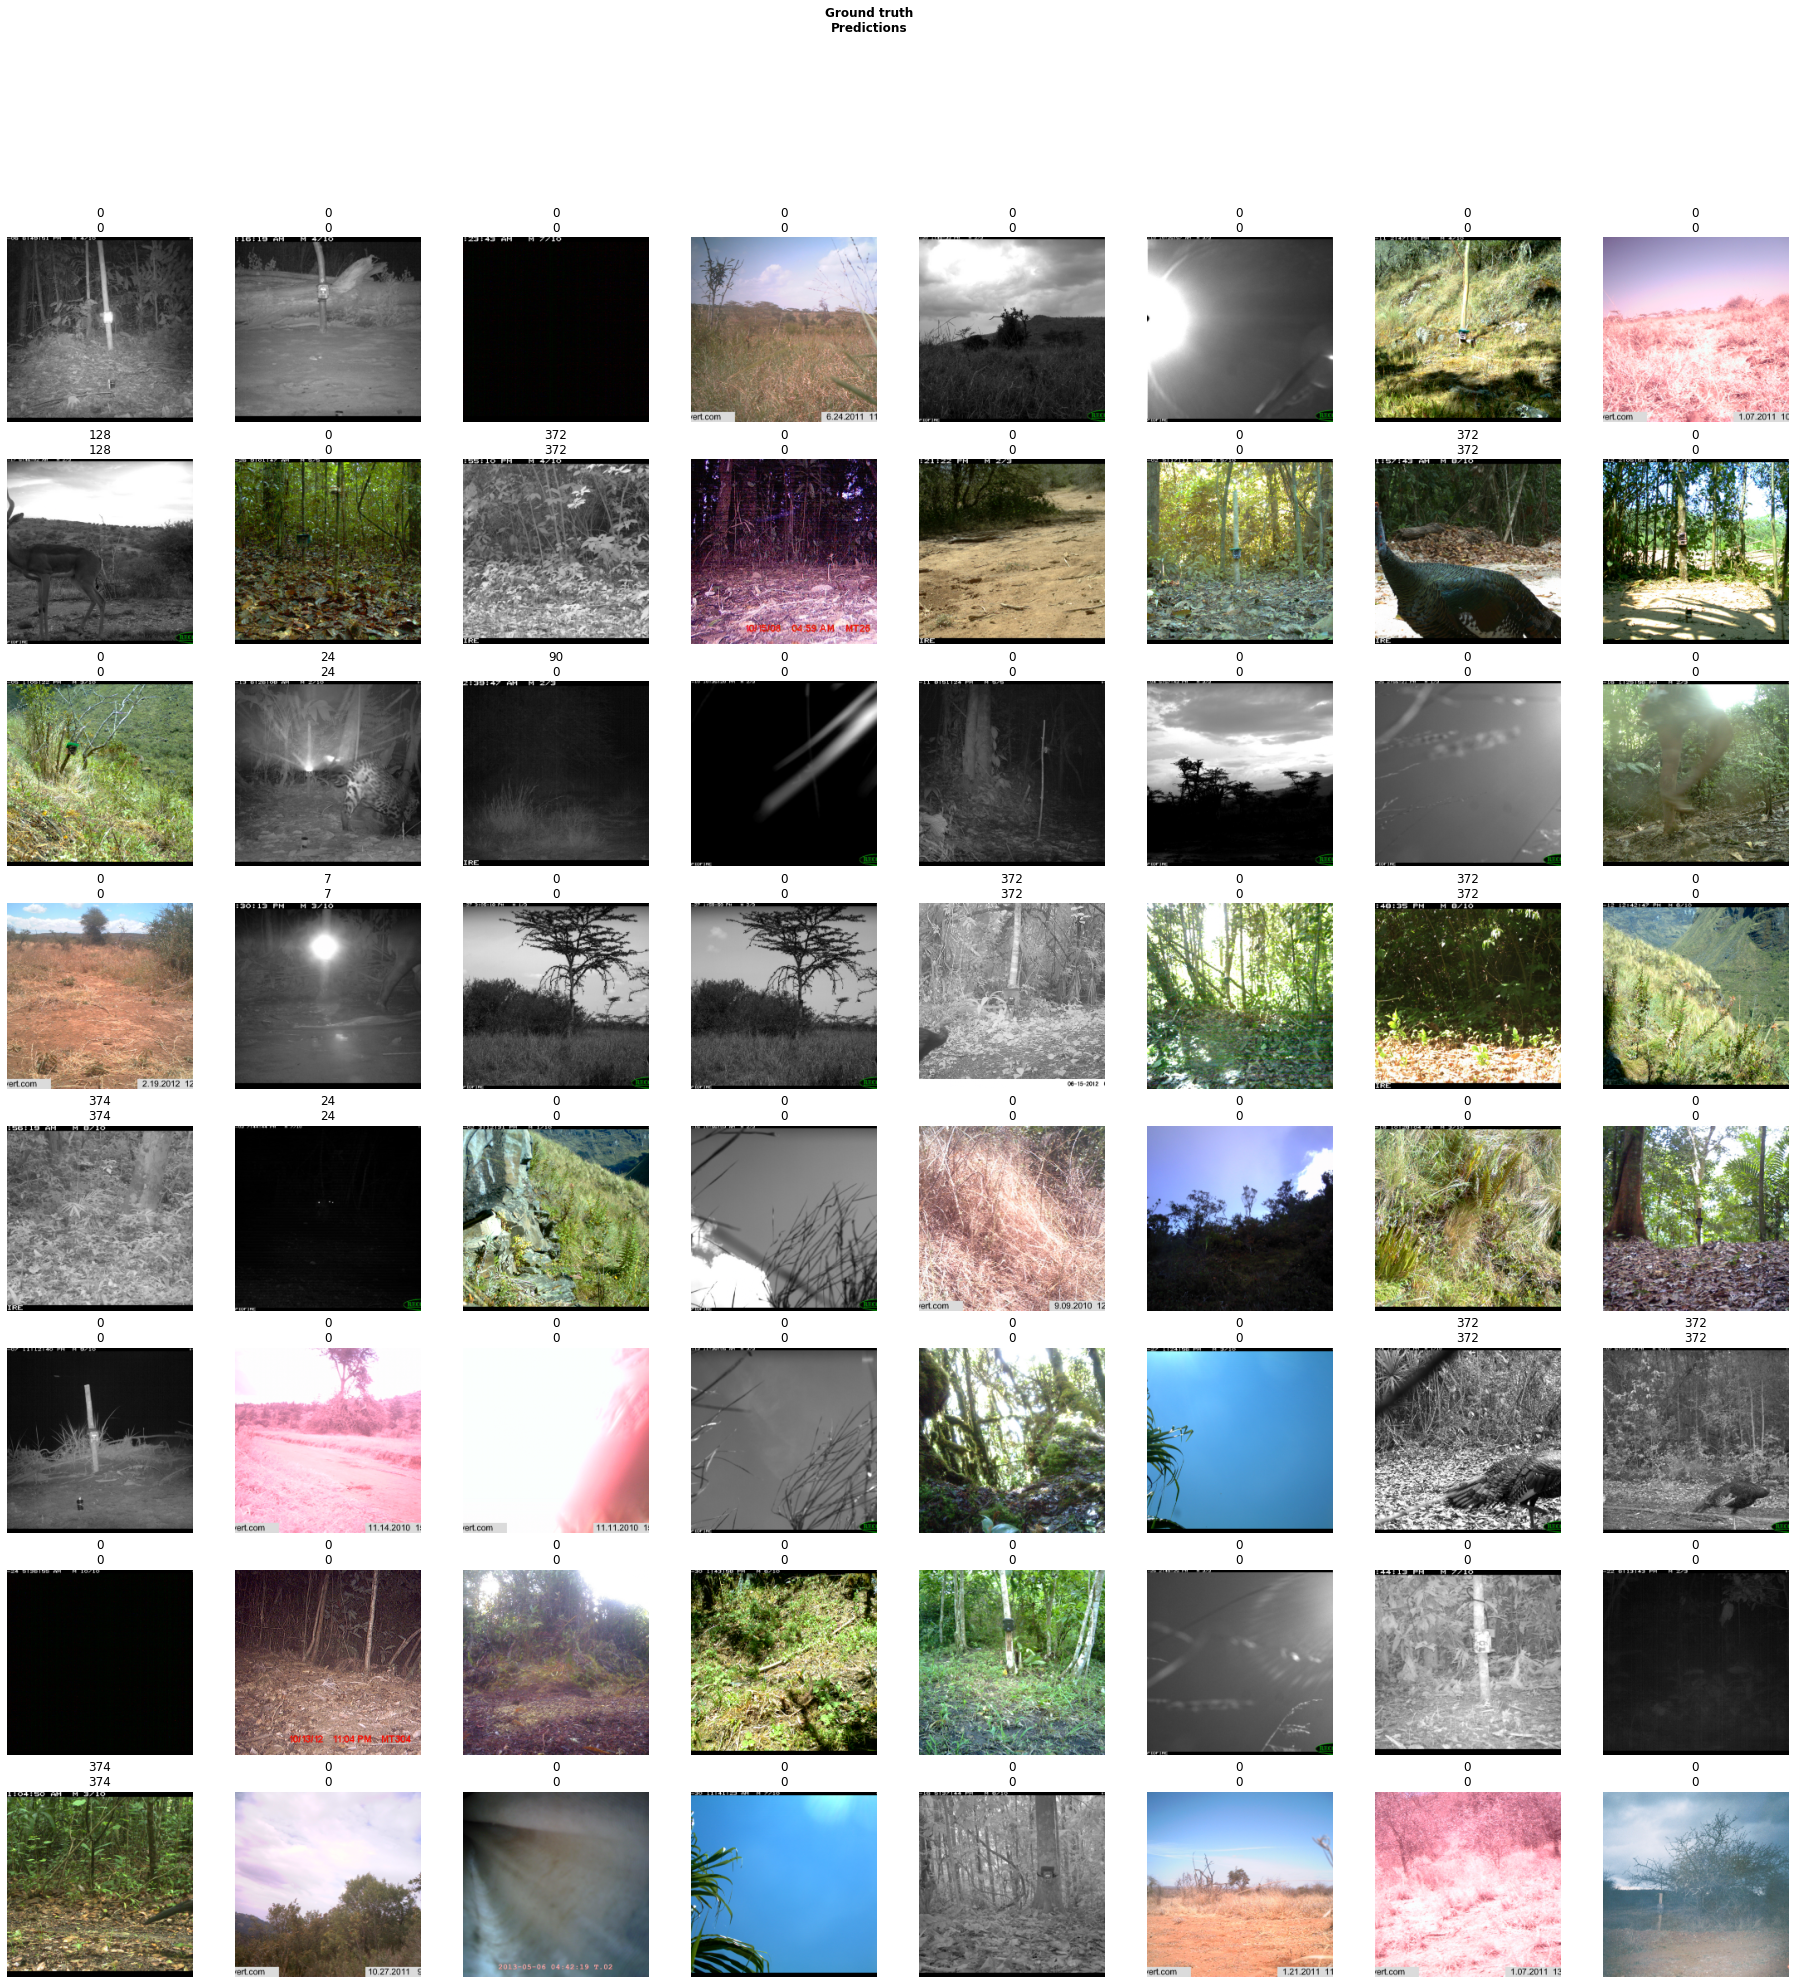

In [23]:
model.show_results(rows=8, thresh=0.2)

Here a subset of ground truth from training data is visualized along with the predictions from the model. As we can see, our model is performing well and the predictions are comparable to the ground truth.

### Save the model

We will use the `save()` method to save the trained model. By default, it will be saved to the 'models' sub-folder within our training data folder.

In [24]:
model.save('Wildlife_identification_5e')

PosixPath('models/Wildlife_identification_5e')

## Model inferencing

This section includes usage of the model trained for classifying animal species on the images stored as feature attachments. 

### Data preparation 

To start with, we have a feature class named "CameraTraps_Sample" having 5 features in it hosted at our enterprise account. Consider these features as camera locations. We have multiple photos against each of those camera locations that we want to use against the model we trained for animal species identification stored in our local drive. 

<Item title:"CameraTrapsSample" type:Feature Layer Collection owner:api_data_owner>
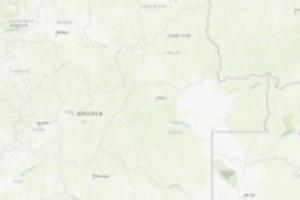

In [25]:
# Accessing the feature layer on the enterprise.

search_result = gis.content.search("title: CameraTrapsSample owner:api_data_owner", 
                                 "Feature Layer")
cameratraps = search_result[0]
cameratraps

In [26]:
cr_lyr = cameratraps.layers[0]

In order to attach images to each of these camera locations, we need to enable attachments to the feature layer.

In [27]:
cr_lyr.manager.update_definition({"hasAttachments": True})

{'success': True}

In [28]:
cr_lyr.query().sdf

objectid                                globalid  \
0         1  {CAF0807E-7655-450E-821C-F9D594443360}   
1         2  {4552E8AC-4F56-492D-96B9-C8223E3B9C4F}   
2         3  {86FC01B4-3252-401E-B139-E4F8BC80AB20}   
3         4  {778945D3-0759-467A-854F-CBE23DD504F5}   
4         5  {C30223FC-C9AA-43DC-AF60-3F2F4F048CF5}   

                                               SHAPE  
0  {"x": 3532970.065299999, "y": -2860638.6310999...  
1  {"x": 3509283.5555999987, "y": -2814882.338199...  
2  {"x": 3516045.5150000006, "y": -2892038.028999...  
3  {"x": 3541828.3214000016, "y": -2800392.364700...  
4  {"x": 3483624.6066999994, "y": -2703827.110800...

Now you can specify the path on the local drive where images are stored against each camera location. One important point to note here is that the directory structure of the data folder path should have separate folders with 'objectid' of the camera location points we marked as their names, containing all the photos captured by that camera.

In our case, as we have 5 camera locations we had a data folder containing 5 different folders with the names- 1, 2, 3, 4 and 5 as the 'objectid' of the points lies from 1-5 (see the spatial dataframe table above). Each of these folders had multiple images captured by the cameras. Below is the folder structure mentioned:

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAWQAAACzCAYAAAC+V2YDAAAGz3RFWHRteGZpbGUAJTNDbXhmaWxlJTIwaG9zdCUzRCUyMmFwcC5kaWFncmFtcy5uZXQlMjIlMjBtb2RpZmllZCUzRCUyMjIwMjAtMDktMDFUMDclM0EyOCUzQTMzLjE5MVolMjIlMjBhZ2VudCUzRCUyMjUuMCUyMChXaW5kb3dzJTIwTlQlMjAxMC4wJTNCJTIwV2luNjQlM0IlMjB4NjQpJTIwQXBwbGVXZWJLaXQlMkY1MzcuMzYlMjAoS0hUTUwlMkMlMjBsaWtlJTIwR2Vja28pJTIwQ2hyb21lJTJGODUuMC40MTgzLjgzJTIwU2FmYXJpJTJGNTM3LjM2JTIyJTIwZXRhZyUzRCUyMkgxdU50SmFlQjg5d3IzUjZxZ0IwJTIyJTIwdmVyc2lvbiUzRCUyMjEzLjAuMSUyMiUyMHR5cGUlM0QlMjJkZXZpY2UlMjIlM0UlM0NkaWFncmFtJTIwaWQlM0QlMjJUYkJIVkxEbzlpTWRwdDdFd3lXOCUyMiUyMG5hbWUlM0QlMjJQYWdlLTElMjIlM0U3WnBkYjVzd0ZJWiUyRkRaZEZZT01BbCUyQm5YSm0zZFdsVmF1MHMzZU1RVndjZzRLZW12bnlubUt5WnBxeVlRcWw0bFBwaUQlMkZiekd2SnpFZ0dlTDdCdkh5ZnlLQlNReWdCVmtCanczQUxBdDZNbVBQTEl1SXNpemlrRElhYUE2MVlGYiUyQmt6S00xVjBTUU9TdGpvS3hpSkJrM1p3eHVLWXpFUXJoamxuVCUyQjF1JTJGMWpVdm1xQ1E2SUZibWM0MHFOM05CRHpJdW9ocTQ1JTJGSnpTY2wxZTJMWFZrZ2N2T0twRE9jY0NlR2lGNFljQXp6cGdvdmkyeU14TGw4RW91eFhtWFc0NVdBJTJCTWtGbTg1SVVsdjdPbWZLJTJGRDdMbnY4NFU5JTJGclc2dWJrNWNOVGF4TGlkTUFqbCUyRjFXUmN6Rm5JWWh4ZDFORlR6cFp4UVBLc2xtelZmWDR5bHNpZ0xZT1BSSWkxRWhNdkJaT2h1VmhFNnFnY01GJTJGZnk4YUpaVnBWNEclMkJlMElSJTJCMlQ3UDFCV0sxcnJadWlhY0xvZ2dYQVdMV2VSRDN3cEhoVksyNURPeWcwaTV5REFQaWRqUkQxUVN5clZQbUJ3Tlg4dnpPSW13b0t2Mk9MQmFoR0hWcjlaSmZsRlN2VU0yNzloa1EzQWtzc0VoWmZPSGtHMEF5TTZRa0cxNzhKc0RiZHdjWTluVEpvUHFCbzVOTjJjc3VxRkJkU3Z5cm5DMFZGY0tzTUNhbG9Ka29vMGVSelNNNWZlWjVKTFRPMTBSTHFpMFhsTjFZRUdEb0ZDWnBQUVpQN3lreWhFbmpNYmlaUjdvMUVEbmVTNHBiRnBvWE85NWVUNlM3VlpCcDFaWlYlMkJYYmxIR0ZsdHE5bjJvYjZLZ3U4NFlETE8zZTNqa0RqYk8lMkIwWTBOTXJCUkMzSkZ0QUVaOUFrWmFwRDFYV24wa04yQklUc2FaUGpwSUVOcllNaElnJTJCeDhQc2h3WU1nVERUTDZmSkFuQTBPMjlVMVpnMHppWUpwWGUzS3FFVTVUT3R1d2VSa1Z1Y3V6VFlCVVUzbHoxYW9kWHQ1WU54b0g5SGRiYWdnTjBLZ0RkQmw3czcxVFY3ak9GMCUyQnRzN05wY0RZRkxJYXZ6bW9XbGpZU0FhJTJCZHFCcGdtYWp3cjFxaWw4VlFUZnNENjBOJTJGbm94aGZReWxlJTJCV3hLanZnbTJoUHl1dXBEcTI5JTJGcGo3MHY3dDJzdVhtbjFwMzVIcTBOcnJUOTh2N2QlMkJoUGR5ZjlucXFRMnZ2Zm1uJTJGRWUwbiUyQjlOZVQzVm83VDFOZTh2MmZmTXhDUTBnVTA3d0lwR2F4QTlwJTJGbUVCMTZrT1dhWnBhdXRFTiUyQmpHeDEwMDNIQlhYWlVORyUyRlpxbyUyRjBPYkJPd0ZadG5Id08yamxwRnY5akt4TTI2bXdPOExkaHNCN3BIZ0syciUyQnRBek5yMHNiQ0YzNjJwRHJuY00yRHJxQ1QxakF4MDNxWWUyM3FUd0dQYTJyZ3BCejlqMEVzRjFNUjFnWGJJb2tBJTJGcTE4a2NkMW5HM2FqSyUyQko3RzNPOFZ1ZjdXZmJ0OHFIaW5vd2N1Yjd0WGlYdTlFdGZmZFM5cFJNWlB1cW84N1NDOXA1JTJGYVpMUCUyQngxVmhTT3YlMkZyY0dMJTJGdyUzRCUzRCUzQyUyRmRpYWdyYW0lM0UlM0MlMkZteGZpbGUlM0V+hAHjAAAgAElEQVR4Xu2df+h/VX3Hn00Yy9EcJcQIY5O2/GcINiIoB/MPbcQQNGaj/EOiCfkjNIVVpKlpUTOdqKtMAn+MBGfQCtbGTKZCDBH8z2BUGI42DIaKNnNzPOu86tWre+6v9zn3nPv9PC98+H6+7/e957zO83Xu477O65z7Oa+CDikgBaSAFOhCgVd1YYWMkAJSQApIAQjI6gRSQApIgU4UEJA7cYTMkAJSQAoIyOoDUYEHAfwlgH+XNFJACmyrgIC8rd691/b7AJ4E8H8A7gLwKYG5d5fJvmNJAQH5WPJmmbZ8DsBFCcrHAbh7JZjfDOATAC4G8KMypm1WyocBfBHAc5vVqIqkAKBJvc57wVsa2PfbAL4JgDDm8eP0+xIwE8b3AfghgPfuEMgvpjbfCOAGgblBLzyiVSpC7tfxjC6Zy/2PBib+IYBfD/X+T4qc75yw5+0AbgNwNYD37DRC/hCATwP4NQCvALhJYG7QC49glQJyv04nkHnYv1tZegaABwCckCp8HsAjAD4J4NEFRuw5ZcFmMs3y2tTelzYE8+sA3AvgLABfAHAZAEbs/vg4gO+m8/i5v+YJAOcB+E66gA9I+o9HrrzavrIR06kArgJwXbLHf86P3pfaxFHVPaHNsV38mtffAuBS1167jO0+P6Pfgm687akC8rZ6L6mtFZD/BQChvBbE1sZDbnK2nRF2b8dPAHwNwLsrGfbqFI0/nMBE8PIwgPF3fnatg5dd83Q6jyDiOYTaiSl1xDkBPkyHyqvUlJ8Xaw8LtuFx1z4+9K8BwBEXHx5jcB2y29r9tvAAqt2equULyFXlPajwFkBmVPYNAP+8IiKOjT0EyAcJV+jiZ1LkyeK2ipAJr1vTqIiQ8nB9IcGM4OVhEXK8xkDFnD8PHyXmfOI/PyVd8yyAK9N8gs0DxOidoyj2U4vGh6SPdbKs0wci1/gwmnqwsxxG3PyZipCvSAEG+zd/fJTuRxD8/A0to2oBudDdW6GYFkBmM/4YwL8WaM+egcwcMpf8cWJzyxxy1CwXNfqURQ7IjLK/PwDkoSF+BDJTHJY+8NGp/51AJLB9emSo28TUgX/I+NU3PpL2qbGYnmEdZi8fXoToHCCfm2zlg5YpIUbsXOJpv1v0zvKH0kQFbonpIgTkaY1andEKyKXau2cgt1plEWE1B8gxZWF52c8CeCykLHIQjUC2lAeBad8RfEyVWEQcHwS5fhMj4hyQh9ISuT7Ec/kCE+E6J4fMCJmHpX5o08mpDD+CaJ53FpBL4ad8OQJyeU3nlthqHfKaCNkiRi4z5PD9K6mRjB4ZafoJMkL6pIGVL0MpC4sS7bubE5AtGp0L5DkRMgE7lCowcPocOsvjHAc/mzupRyD7SVArl5/59ImAPPcOOYLn7R3IR9BlBzd5LIfsh/dDw3irfAyUOeCMRcgW0V6yMkIeyyHTZi4ptAlJL6DPhccUBiN1fwytwPBtjRGyReOMshUhH9xtj0YBAvLR8PMQhMZWWfB8D+QILp8ieKN7W9ImBa1sX+9QDvkdAysz1uSQc6ssmLsdW/UxJwJfEiET0NSGh3LIR+/eOrjFAvLBEu6ygDXrkP16Xr5l6d+O9CmLuAbYXm3n8jj7nass+Lo7D77Y49cue9suB/DWdB1zuX51SBR+aB2yL8ufb5OJc+YgIpB9iiNGyK8BcGZK61gdrNdWWTDKvh3AaWlSzz/M4qv/vh5vJ8sb02GyQyqHPClRsxME5GbSH7mKx3LIOTHi5NzZadXC2BK4LYWNQPY55JwdMWL/QHpJarO/xSIgb9lFltUlIC/TS2evU8AiaIsac3lmS41cmKrxeVt+x1ws1z7HtwrXWXXYVfbyjE+7DAHZR+6sMY4GzgFwx2GmLLtaQF6m15ZnC8hbqq26pEAHCgjIHTghY4KA3K9vZJkUqKKAgFxF1iKFCshFZFQhUmA/CgjI/fpKQO7XN7JMClRRQECuImuRQgXkIjKqECmwHwUE5H59JSD36xtZJgWqKCAgV5G1SKECchEZVYgU2I8CAnK/vhKQ+/WNLJMCVRQQkKvIWqRQAbmIjCpECuxHAQG5X18JyP36RpZJgSoKCMhVZC1SqIBcREYVIgX2o4CA3K+vBOR+fSPLpEAVBQTkKrIWKVRALiKjCpEC+1FAQO7XVwJyv76RZVKgigICchVZixQqIBeRUYVIgf0oICD36ysBuZ1vuLvEc+2qV81HVQEBuV/P7xXItiWOKWt/JLxfpX/ZMu5+/BCA+wHcIDDvxW3Hhp0Ccr9+bAFkwujfAHCH4QdWSMN90q4H8DEA3PYmbvOzosgml3wrbQ//ctoVWWBu4oajV6mA3K/PWwCZanCozn7xPQBXrwSzqep3HPZbufer+s8s4+adhPLxAF4C8IrA3LvLjg37BOR+/dgKyB9KQ3XC6FkATx0A5rFt2seUt7a39M4FALjzsB0EM4+7AHDzy1rHml2naYvtI8ff/a7K/vO4I7W1Yc4Oz4e0d2jXaZYX97Tzdvvv/F533g62Lbd5aW5vwEPaUf1aAbm6xKsrIJTeAuAfVpew/sKbAXDjSjsI5v8E8FcLImbbFPNhAPcuNKUUkBnZ+j7O//OI/X7o8xZAjprFXZA9eD28uFHp6Wn7ej5IbSv6EwGcAeC61O6h8ha6ZvHpfpT0eBppsE8wJXYNgDsBcKdq//B+JvUZ2s2R1VwdFhvX2wUCcm8e+YU9HDL/AYCvNzCRN/hvunoZHbKvfATAjTPsMbA87WAw47JuTmmVsiC8DKaElM/Bv5BgRk15WGRIrT3YxkTM5fR9hHxK2kGaD+ErAfioOkbvJwDgw5O25o4YffuHh9+h2j+MHgNwC4BLU9n+GtZzE4CoQ6zfR8hXAHgewFnp5yrXL/0kND/nPMplrXbPFpC7YcCvGEIg8/iTjU38CwB/C4A325r8qd203BJ+aWS8cVOz1bWa1IvwyqV8/FDdJlIJxc+lFvno2TcyB8MI5Edc2sNHp/53lkVgnzcB5Jg6yD0UcpE0+1Ausp+bsiCQz022+uj7SReJW/ROvQTkXu7EjuxoBWRGXicB+N8VE1mHpCl6kb7lsrcIq7lAJrQ4tOcQP3fNWD4/ApmgI3C5Usa+Y/R4rYuIYzSf8198COSAHKFrfenCkBP39SwBMq+z1A1tOhnAg2k0YABunndWhNwLBn7VjhZA/lMAfw/gb1auwY2TNNaqva1FbvViyNoI2ac5hh6K5peLErhjbxtKWRik7DvOKxDIlkaYC+Q5ETLB6lMF8eGRi+yXANlP/hmQ+Znl3pk+EZD75WFzy1oAmY1uBaPmgndgwFgOmdGqHR5EBmCmiBglRyATMrdNpBbGImSLaLk2fU2EPJZDZnssH2zRKz+LAJ4zUojuizlkHyFbNK4IuYNOvxcTWgF5L/oci3bOWWXBdsfI0CI+Qs0DmOf6ybGcZkM5ZBvVHJpDXpMbHoqQz3dplKEH0xSQqQt14sEUD7VSDvlYvIsqtUlAriRs58WWWIdsMCWA7gnttVUTXBLHFRIXA/C/c5UFP+PxHgB+DbC37fL0Ag3L4ESZT5tEiYfWIfuy/Pk2IelXPzyRifCnHkyEOFMvnNTjyO9MAKeGnLTVwzpuB3BauoZr0E0fPzqxCJ45aMvZ23n8bkyHya6nHPKkRM1OEJCbSX/kKh7LIefEiJNzZ6eIc2wJ3JbCxpRF7gUSb1OcWOQLQFwvHYFcrR0CcjVpDy5YQD5YQhUwQwGLon1kapHl0Dphrnrg4aNWplp4DfPY/poZ1Vc5xd5O9GmXISDHSeg4GjgHwB1VLMwUKiBvqfayugTkZXrpbCmwewUE5H5dKCD36xtZJgWqKCAgV5G1SKECchEZVYgU2I8CAnK/vhKQ+/WNLJMCVRQQkKvIWqRQAbmIjCpECuxHAQG5X18JyP36RpZJgSoKCMhVZC1SqIBcREYVIgX2o4CA3K+vBOR+fSPLpEAVBQTkKrIWKVRALiKjCpEC+1FAQO7XVwJyv76RZVKgigICchVZixQqIBeRUYVIgf0oICD36ysBuV/fyDIpUEUBAbmKrEUKFZCLyKhCpMB+FBCQ+/WVgNyvb2SZFKiigIBcRdYihQrIRWRUIVJgPwoIyP36SkBu5xvtK9hO+yNds4Dcr/tbAfnDAL4I4LmV0vg/+m3bBW2248JKm/1l3P34IQD3r9x5u4AJKuKoKiAg9+v5VkDmjg/HAbhxBZC4c8Q1AO4EwK18ctu396v6zyyj9twe/uW0K/INBzygem+r7OtIAQG5I2cEU1oB+UMAPg3g1wC8ciCQ4hbw/ar9y5a9NUH5eAAvFdBhL+2WnY0VEJAbO2Ck+lZApklMMbw22XYIkNZGyNzFt/VxAQDuPGwHdeBxFwBufln7oHa2s3Gsiw+6WwBcmkYifodmnmt7yfF3n0Lye8b5Mrd6cMZdor0Nsa/4HbOvSjs883zbL89fO5Qa85uc9rDP36z+IiDPkqnJSd8D8LtNah6u9CcAvgbg3TNs8lu8ezjMuPSnp5QCMiN838f5fx6x3w993hLIBiMPItOOaaGbALwNwHkAngFwPYCPpQep3w2a19ybYPZoghk/4/b1Wx8GUttMNT4Q7gPwbQCXpQfh+wFcnU5iex9ObfHXmRZD323dviL1CchFZKxSCIHM4/eqlD5eKG9yQpXHIRGygZkAIBD2crRMWRBcnFh8HMDrB+BJWJ+afixC9rp6zelHH0nnRiw+Qj4l7SD9LIArAfjo0z9oGW2fkB6enC/IHQbNp9MJcfdnm3fg17+VgBwj2txoYSwK9t9dAeB5AGelH/+g86MLfk7t+VBoElULyP0iohWQmUP+VJrYOzSHvNcIpodJvSEIGThvBUB4DAHZpzOeStG0RZCEPY8YIUcgPwLAIll/jf+d9hHYjNLHgOzvsKGUhbWToOZEaoRhrg/Z53dnHvYRyOe6EYWNGp50Iwg+ABmJ8xCQ++ViM8taAfmQVRaMoAgLphx4k8ZcZzMxF1Tcy7K3ISATaA+mNIWPfK15Q/Cyzy50kI1yRCCzHtbPuQT7jg+Aa51vo6/nSByBzDIs3fLOASBb9LomRxyB7B9Epi21PN8BuHneWRHynG7U5pxWQC65DpnKrckht1H8F7X28GJIBDJhcUaKbocedD41YBFwPG9JysKiRAPyzQnIFpWXALI9YJjOGpsA9nlxW9M+NkFIT0Yg+1RJLioXkEfuvLkz9FOOaX1zr62/FZDX2qvryioQgTy0uuCJMAzn8J3DcTviPZQbsYxFyAbDSwpHyD4f7ZUbWgkS7Z7zMBiLkC31ogh5QZ8VkH8mVotJvQVu0qmVFJi77C3mib05QxEyh+iWjrBzh3LINrKpnUMeenicFlIJQw8WpsUuTmmVIRdEIPP/LIeHcsgzO63ljPjk/yc368rLmXBnHoyHPUXPAXBP+oyTEA9kzmsyYzqzzbnTFCEfKODOL58LZDaTS8a48sIfBlS/isAiasvvG9ROTLlhAo6rLPgvj/e4e433kI9qLwfA1Sgsg6s5/NxBTvq165BjDjmXWvCaRSAzDXVm0skvvfPMuR0AHwa29C4HfV+Pf5ix3XN0yHbNnnLItoD9orTkx894ctkKD+bG4lIq72T/NN/rkitzloC8c6LuyPyhZW9TKw1iXvdsAFy1MHfFRW15xnLIYw8M4wz/5QtADPI2+1ssPQE5PvVyT8G43CX31J1aFuOdwqf/b9TuISvK/zEAtkOHFKilgL2EYlHj1H1no1QfbbOPMhXCHHYPo1HLt/u0S1z/TD39W4z8v89fM6DjCPyOWsIPldsTkGOeyHcMvsIah2VDYkeB2eY9zvLT7pavTm/ZB1WXFJACSYGegJyLkD+a/uqYLW7PRciWP86dtzenC8h785jslQIHKtATkH3O1781E4FsSfgYIUcgx/MOlGrzywXkzSVXhVKgrQI9AZlK+Blh5qrelP7ACGc++TonD74xxMNyQj4H9v2R89oqvbx2AXm5ZrpCCuxagd6AvGsxCxsvIBcWVMVJgd4VEJD79ZCA3K9vZJkUqKKAgFxF1iKFCshFZFQhUmA/CgjI/fpKQO7XN7JMClRRQECuImuRQgXkIjKqECmwHwUE5H59JSD36xtZJgWqKCAgV5G1SKECchEZVYgU2I8CAnK/vhKQ+/WNLJMCVRQQkKvIWqRQAbmIjCpECuxHAQG5X18JyP36RpZJgSoKCMhVZC1SqIBcREYVIgX2o4CA3K+vBOR2vulhk9N2rVfNzRQQkJtJP1lxCyB/GcCXAHAX4BKH38GlRHlblPEGAA8BuD/92dfntqhUdUgBKiAg99sPWgD5hwBOSED65IFgtr/cx7/OZ9vS96v2L1tG7U8H8HLao/EGAALzXry3YzsF5H6d1wLI3NTy8wnKz6c/ZboGzPzb1tcnaZ/eIZC5eSf1Px7ASwBeEZj7vVGOJcsE5H69SSAwl2l7mG1l6VcBnOQqMzB/xm0rNWWL7XN4cjpxaYTM3X5bHxcA4NZhdhDMPO5Km1/Wss/v7Oz3eGN9tlec1c198B7L7Dpte+T5a+LuzVaO3+S0xoaefms1P2LybaUttk/fH7nd5M1Gv4ef/7vpuRFYbm/AWn4rUq6AXETGKoX8HYCzANju01UqGSiUmwIwbeEPbrb6NQDnzTCCN9/708YCfrfwGZf+/JRSQGZk6/s4/88j9vuhz1sA2bYns23IfA5+7qa9fjfoUwCc4UYoLXL6QzsBWfvmPgi83bzmFgCXAngqjVysvCV9rMtzBeQu3fJTowxKpeA0p6UnAmAe+bh08rOp01+dtkOfKoPQuAbAnWk7+BYAmLJxzvetUhaE163J999JO+hQQ+6Kw8N/N9SOKWh7WPtI2IOREOcO0vT9lQB8VB2jdz642T9pa+6I0PWbGXMnINZ12chu1fH62IZcH/MRMgMDjvQY4PDHR9Ux2uak7pg9c/rP6nME5NXSVb+wBZBvBHBJujkYfcwFsYkxtOs3v9vbxF6rSb0IHx8NUke/83pMZ/D7qWF63Nnd+4397WIABDK3S/MpD57HtJOHH8sisDlqGgPy0ObF9pB5Z0hNWJ3+5rL0173pw7GI218XgXxusvUZACyL7XnS/e738RSQq+NtfxVsDWRGx4TwDwB8ZGZEPKXqHiPklsveYvTngUz/GMheSEN1P2E6FR37siJAY4Rs9TCKtu/4UL3WRcQxms/1hfgQ8G38YLqIcLSH+UVudU8upeEjddvsONYfgWwPFf5Lmzi/8WCI0KceaFP9/eDvFSEfLGG1ArYGMhvyLgDfKNiiPQKZzW/1YshYhBwhOgRvi3LjxNwQ7Lybh1IWFiXadzcnIDN3S1vmAnksQo52xv5i4PSTwmtTFrYpsgcyP+PyRmurgFzw5j/WimoB5GNNw721ZyyHHOEV4TEEL0tj3DaRWhiLkA2ATGWtiZDHcsgvBgf59EQu4o/QzuXFxyJkK0MR8t7ukIb2CsgNxW9U9dgqCw/ceB7NjblWfjaWphiLkJlDtlSAB+CaHHIu5/tASrvcnVIU0dZcBD4UIQ9NxEUg8/82OaoccqMOvudqBeQ9e2+97XPXIfuJ0lw0SQDdE0yxVRPMSVuKw//OST1O7vHgi0J+8tDbdjkArkZhGZwoG1sBMncdss8Hjy2J8+3yq0D8QysCmWmoMwGc6iYsbQTBBxDXOd8OgCs/mMLgGvRcCsjX4+1keVMrYUZ7hnLI62+c2lcKyLUVVvmmwFgOOadSjFTPTqsWxlZcbKl4BLLPIefsiOmQD6TJ7RovywzaICBv2UWW1SUgL9NLZ69TwKJNW3KWm9iyKNzeHPVvzvE7ridm+iHmhddZddhV9naiT7sMATku04yjgXMA3HGYKcuuFpCX6bXl2QLylmqrLinQgQICcgdOyJggIPfrG1kmBaooICBXkbVIoQJyERlViBTYjwICcr++EpD79Y0skwJVFBCQq8hapFABuYiMKkQK7EcBAblfXwnI/fpGlkmBKgoIyFVkLVKogFxERhUiBfajgIDcr68E5H59I8ukQBUFBOQqshYpVEAuIqMKkQL7UUBA7tdXAnK/vpFlUqCKAgJyFVmLFCogF5FRhUiB/SggIPfrKwG5X9/IMilQRQEBuYqsRQoVkIvIqEKkwH4UEJD79ZWA3K9vZJkUqKKAgFxF1iKFCshFZFQhUmA/CgjI/fpKQG7nm1abnLZrsWruQgEBuQs3DBqxVyDHP/rtt9jpV+1fWMb92R4CcD+AGwA8twejZeOxoYCA3K8f9wrk5lupF3Dpt9L28C+njTgF5gKiqohpBQTkaY1andECyF8G8KW0C/Dadue2o19bXovruHknoXw8gJcAvCIwt3DD0atTQO7X5y2A/EMAJ6Qh+ydXgtn2MzNl/U7Cc9W2ts89v8Z5F6Sdh61sgpnHXQC4+WWtY2zXaauTGvs94vx+d36vO54fd572u1VbeWM7PJdoZ27X6Zjesn39ot1DNvMcXn8LgEsBxM1VdzlSE5BLdLc6ZbQAMrd9/3yC8vMAuD36EjAbGB4GcC8A3hS3AThv4IYZU60UkBnZ+j7O//OI/X7o8xZAjvrFXZBpuz3wPLz8eXE36AjvOr01X6o9YK4D8HgaabB/PADgGgB3pr7h4crS3g/g6lTsTQCsT1lNptXbVvSvrTWYXZ+APFuqzU8klH4HwBc3rvmrAE5ydRqYP5OG8UvMiYBZcm3Lc1ulLAivWwHQ94z4PFxfSDB7OgljEXLU2IPtqXQNd4N+dERQHyGfknaQfhbAlQD8pGyM3jmaMltzxcfomxH76QAuCztUj/WVoTQYPzs1/UxFyFcAYD8+K/34iJsaM/Dgwc85qRtt26wvCsibSb24oj9LN9N/L77ysAvelCJkX8qPAXwtRSJLSrebbAoIS8rc4txWk3oRXrkheYx6PeROS1E0P+PBkQpBxCO34iUCmYCyCNxH3/53lk9gT41+YuogRvDmTx9J+4fHEKjNXj68CNE5QD432fpM0oQR+5Pud4veaY+AvMVdpjomFTgRAPPIx6UzGSUxyuLQkUPMqWMswvvR1MWdfN9y2VuE1VwgUzrLFX/BASVeT6AORYARyDyP5dFn9h3Bd62LiKOvc+6LEXEOyEPpGYte44OE5z4IgHCdk0NmhMyDEDatTk5lnO/0ap53VoTcCQU6MeNGAJekoeQSEHvz/URNnGDqpJmTZrR6MWRNhDyWsogTXTnAD6UsLEq0725OQLZodC6Q50TIuQeFOcpDnCmVMxJc507qEch+EtRSIPzMp08E5MlbQydspQCjY0L4BwA+MjMi3sq2o1LP3BGGT1lEKI3lYnOrKcYiZIMhH9RrIuSxHDL9ygk75sUteh3ytW/jnyc7/HlDD34P1xghWzTOKFsR8lG5u3bYzncB+MYO7T5WTJ6zyoJt9UAeipDvA3BREsUDZygtwNOGcsi2XPHQHHJulQVz2zl7YqSamwhcEiGzTJ9XVw75WLlr1A4pUFGBNeuQ/TU0LbeeN+aXuULiYgAcHdnvTAnwMx5cBumv8fVcDoCrUXgdc7l+dUiUZ2gdcrTZrjHb/frpsclIn0P2qzFihMw01JlpVYbXx/LUjLJvB8BJUaZr3ug0ifMfvh7/MGMbxnSY7DbKIU9KpBOkwDGvwFgOOdf4ODl3dlq1EPPWrcSLQPY55JxNMWLnC0CczN5sQlpAbtVdVK8U6EMBi0QtasxNbPm3AWm5z9vyO6ZGuLzxxQ6aZS/P+LTLEJDjm4JxNHAOgDu2bI+AvKXaqksKSAEpMKKAgKzuIQWkgBToRAEBuRNHyAwpIAWkgICsPiAFpIAU6EQBAbkTR8gMKSAFpICArD4gBaSAFOhEAQG5E0fIDCkgBaSAgKw+IAWkgBToRAEBuRNHyAwpIAWkgICsPiAFpIAU6EQBAbkTR8gMKSAFpICArD4gBaSAFOhEAQG5E0fIDCkgBaSAgKw+IAWkgBToRAEBuRNHyAwpIAWkgICsPiAFpIAU6EQBAbkTR8gMKSAFpICArD4gBaSAFOhEAQG5E0fIDCkgBaSAgKw+IAWkgBToRAEBuRNHyAwpIAWkgICsPiAFpIAU6EQBAbkTR8gMKSAFpICArD4gBaSAFOhEgSVA/jiAa4Pd3wTwXgA/2qA9rP+7AO4Ndb0ZwH0ATg2fXwXguhG73g7gfACXAXjRnfdqADcBeHigrg2aWbyK6Ld3AHh0opacNvEyaV/cXZsUOOa3v079/+5kydA9somRR7GSpUCmRh5yhPHJE+ArpesYkG8BcCmA7yyo7CgAmZq9wT107Ea8aALKS4As7Rd0uk5OZT+Y47e5/aCTZu3fjEOB7B12fIooz0qyWITKc/j76wF8O8HhNACPpPO+4IBBgLwGwJkp4rXvzgFwTzr/fSFynepcFvFemK63CDF2Noskv5LO+3qqZ+z62C4fabfuHblIn+3k4SMhRsyvA3ArgE8AODGNHp4FcCWA3EioF+0/CuAGAObj2Eda+6K3+sf8Zv1mKEL2oy2vMe8lu5+3HDX3puvB9hwK5Hhz2zDfO5w3920AzksRrP/uqTQ8ejpF2SyPzmXkzeuYirBobm2E7KNEPgjMFoMOUxYEPodmvt7PJiBbGzkyoG3+et+ug51RoQC2hw+yofSNv/GGgMwbzG46r4E3cwrIW2nvR2p8sFwP4GMbpdIquK16kWuAzHvk9BQ8vdHdm0+6BzlHqPQFj5harN6oY6GCpUCOOWQf3Xo9YrTFG9NyzfzXHMuI0keqV6RCCL8IjCU5ZLOLxTEfzKc9oeOjxu+7HDLr9flpq+sfU8eiPf56ix58u3rtD/QFb444cpkCsm8bb2BGzhcHyA3lIltov2XqrFc/L7Frrt9YJgMVG4H4eRV/j9jIaknKcIm9R+bcpUCmMLmJMj9s4XlPpKjYR6IEsEVtXmQb5nzQgXEJkHP5MOAdJsQAAAGqSURBVIORAZV1WkcyIE91Ng8zs5mRowd6T6mKsc7rH0gPhIfVUMrCJjzHgNyL9n44PWfi8sjc5AMNXRohx5SQFWkjLw/4XJB2lPWe3fZSQI7gG7u5x6IZHwWXAHIsY02EnHv69z7hkRu6m/4xhxzTTD5CZluHRgNzb+y1o5M12vu+p4htGAVz/RYjZBtpjgFGo5XZ+P3VE2sBmU7hZBDzxjFCjp3B5xl96qAEkC0itpUGuRwyPzfgWO56KIfsVylYZ43L5g5wR/FLY+7XHpy8sSxCtvx99BlzyBZp1swhl9DeP8iVQ57uRkuBbPMslmq0CXz2o8dCOks55Gn9s2eUAjIr8KkIznbzRsutZczNyo5FyFZ+7VUWTJ/w578yqyys/t4jZHN6XIfs9fNDzcsBvDWzyiI3DJ2a1Fu6wmWt9jFPrpTFOBTWAJlpOd+X/ESxv/eVstgIyAdUo0ulgBSQAlJgSoElEfJUWfpeCkgBKSAFDlBAQD5APF0qBaSAFCipgIBcUk2VJQWkgBQ4QAEB+QDxdKkUkAJSoKQCAnJJNVWWFJACUuAABf4fFtXlSg5Bs+kAAAAASUVORK5CYII=">


In [29]:
# path to images captured by each of those camera locations.

path = r'./data'

As there could be multiple images captured at each point, we need to create a separate feature for each image and then attach the image to the feature added.

In [30]:
for folder in os.listdir(path):
    count=1
    oid=folder
    for img in os.listdir(os.path.join(path,folder)):
        if count > 1:
            cr_lyr.edit_features(adds=[cr_lyr.query(where='objectId='+folder).features[0]])
            oid = cr_lyr.query().features[-1].attributes.get('objectid')
        print("Adding "+str(img)+" captured by camera number "+str(folder)+" to feature id number "+str(oid))
        cr_lyr.attachments.add(oid, os.path.join(path, folder, img))
        count+=1

Adding 0978.jpg captured by camera number 1 to feature id number 1
Adding 1085.jpg captured by camera number 1 to feature id number 6
Adding 1086.jpg captured by camera number 1 to feature id number 7
Adding 1154.jpg captured by camera number 1 to feature id number 8
Adding 1155.jpg captured by camera number 1 to feature id number 9
Adding 1094.jpg captured by camera number 2 to feature id number 2
Adding 1095.jpg captured by camera number 2 to feature id number 10
Adding 1385.jpg captured by camera number 2 to feature id number 11
Adding 1386.jpg captured by camera number 2 to feature id number 12
Adding 1387.jpg captured by camera number 2 to feature id number 13
Adding 1105.jpg captured by camera number 3 to feature id number 3
Adding 1106.jpg captured by camera number 3 to feature id number 14
Adding 1332.jpg captured by camera number 3 to feature id number 15
Adding 1336.jpg captured by camera number 3 to feature id number 16
Adding 1338.jpg captured by camera number 3 to feature 

Note that there are separate entries in the feature class against each image captured.

In [31]:
cr_lyr.query().sdf

objectid                                globalid  \
0          1  {CAF0807E-7655-450E-821C-F9D594443360}   
1          2  {4552E8AC-4F56-492D-96B9-C8223E3B9C4F}   
2          3  {86FC01B4-3252-401E-B139-E4F8BC80AB20}   
3          4  {778945D3-0759-467A-854F-CBE23DD504F5}   
4          5  {C30223FC-C9AA-43DC-AF60-3F2F4F048CF5}   
5          6  {916683B5-6530-4BC6-B3A2-F4D79FD15DA7}   
6          7  {0E3DEBAB-CA77-42B4-83C1-1A8CB8D38095}   
7          8  {4AB59101-82A5-4C88-9EE8-2719B5254B2C}   
8          9  {17D4C1CC-9330-4A3A-BB72-2692B23D2335}   
9         10  {B43CDD4E-5B6D-43AD-A159-6BA2008052E7}   
10        11  {3B71EDBE-0B9E-445F-8CAB-26B3FF6FFC3D}   
11        12  {C1A9C795-E039-471E-BB56-8850C34ED073}   
12        13  {2A481867-E024-4484-BBA9-C39712750D21}   
13        14  {E6E07370-3E31-4727-A54E-BD8962203CA5}   
14        15  {4BD065B4-6580-44DB-921A-1FFF489CE925}   
15        16  {034414D0-07A8-456B-BD3D-9BAA1AE45A95}   
16        17  {9E6A468F-4F90-4817-84B1-4180DB08B8D1}   
17        18  {C69828E0-4A8B-4D36-A7AE-732E3B636A52}   
18        19  {4481F8BB-BE67-4330-8CE5-E3608B112662}   
19        20  {6679F5C7-0FF8-45C7-814B-7C363F8018B2}   
20        21  {9B4C346E-C0A6-4B24-95FD-66301BF2E554}   
21        22  {9AD4C969-89D1-4746-8AB1-FF2257F776EF}   
22        23  {75ABF981-0C50-4100-B129-0CE60E1665A0}   
23        24  {B14039F7-BC0F-4294-A63C-D799D993827F}   
24        25  {12783D5D-1F07-4D05-A050-7552BAB7F192}   
25        26  {B472BCAD-D2FE-40F5-AD5B-CED6D396A4B6}   
26        27  {0702D64E-0696-45CD-808C-4C793E5A26BB}   
27        28  {89E22431-8C50-40E8-9362-BD1A6452E6A6}   
28        29  {F4451106-3BEE-49FB-A3A7-3C29C450E861}   
29        30  {F59E3F9F-441C-4762-A5FA-4FC24EDA082E}   
30        31  {6A2B2260-46F1-4B71-8B3D-F1C6AA796037}   

                                                SHAPE  
0   {"x": 3532970.065299999, "y": -2860638.6310999...  
1   {"x": 3509283.5555999987, "y": -2814882.338199...  
2   {"x": 3516045.5150000006, "y": -2892038.028999...  
3   {"x": 3541828.3214000016, "y": -2800392.364700...  
4   {"x": 3483624.6066999994, "y": -2703827.110800...  
5   {"x": 3532970.065299999, "y": -2860638.6310999...  
6   {"x": 3532970.065299999, "y": -2860638.6310999...  
7   {"x": 3532970.065299999, "y": -2860638.6310999...  
8   {"x": 3532970.065299999, "y": -2860638.6310999...  
9   {"x": 3509283.5555999987, "y": -2814882.338199...  
10  {"x": 3509283.5555999987, "y": -2814882.338199...  
11  {"x": 3509283.5555999987, "y": -2814882.338199...  
12  {"x": 3509283.5555999987, "y": -2814882.338199...  
13  {"x": 3516045.5150000006, "y": -2892038.028999...  
14  {"x": 3516045.5150000006, "y": -2892038.028999...  
15  {"x": 3516045.5150000006, "y": -2892038.028999...  
16  {"x": 3516045.5150000006, "y": -2892038.028999...  
17  {"x": 3516045.5150000006, "y": -2892038.028999...  
18  {"x": 3516045.5150000006, "y": -2892038.028999...  
19  {"x": 3541828.3214000016, "y": -2800392.364700...  
20  {"x": 3541828.3214000016, "y": -2800392.364700...  
21  {"x": 3541828.3214000016, "y": -2800392.364700...  
22  {"x": 3541828.3214000016, "y": -2800392.364700...  
23  {"x": 3541828.3214000016, "y": -2800392.364700...  
24  {"x": 3483624.6066999994, "y": -2703827.110800...  
25  {"x": 3483624.6066999994, "y": -2703827.110800...  
26  {"x": 3483624.6066999994, "y": -2703827.110800...  
27  {"x": 3483624.6066999994, "y": -2703827.110800...  
28  {"x": 3483624.6066999994, "y": -2703827.110800...  
29  {"x": 3483624.6066999994, "y": -2703827.110800...  
30  {"x": 3483624.6066999994, "y": -2703827.110800...

In [32]:
# To check attachment at feature id - 1

cr_lyr.attachments.get_list(1)

[{'id': 6,
  'contentType': 'image/jpeg',
  'size': 232422,
  'name': '0199.jpg',
  'attachmentid': 6,
  'content_type': 'image/jpeg',
  'data_size': 232422,
  'att_name': '0199.jpg',
  'globalid': '{8E6024FF-028F-4C9D-A85C-8A2D0E6B09FF}',
  'keywords': '',
  'exifInfo': None},
 {'id': 8,
  'contentType': 'image/jpeg',
  'size': 71805,
  'name': '0294.jpg',
  'attachmentid': 8,
  'content_type': 'image/jpeg',
  'data_size': 71805,
  'att_name': '0294.jpg',
  'globalid': '{0E905B24-6F48-45B9-BBCE-D7C55F773A36}',
  'keywords': '',
  'exifInfo': None},
 {'id': 10,
  'contentType': 'image/jpeg',
  'size': 220632,
  'name': '0478.jpg',
  'attachmentid': 10,
  'content_type': 'image/jpeg',
  'data_size': 220632,
  'att_name': '0478.jpg',
  'globalid': '{1565AEF8-0575-4A50-B717-A114FDF0D46A}',
  'keywords': '',
  'exifInfo': None},
 {'id': 9,
  'contentType': 'image/jpeg',
  'size': 76469,
  'name': '0412.jpg',
  'attachmentid': 9,
  'content_type': 'image/jpeg',
  'data_size': 76469,
  'att_

### Inferencing 

Accessing the published model from the gis server.

In [33]:
fc_model_package = gis.content.search("title: Wildlife_identification_5e owner:api_data_owner",
                                      item_type='Deep Learning Package')[0]
fc_model_package

<Item title:"Wildlife_identification_5e" type:Deep Learning Package owner:api_data_owner>

In [34]:
fc_model = Model(fc_model_package)

In [35]:
fc_model.install()

'[resources]models\\raster\\0bc2be911a2f456eb2f98b2ee242a8de\\Wildlife_identification_5e.emd'

In [36]:
fc_model.query_info()

{'modelInfo': '{"Framework":"PyTorch","ModelType":"ObjectClassification","ParameterInfo":[{"name":"rasters","dataType":"rasters","value":"","required":"1","displayName":"Rasters","description":"The collection of overlapping rasters to objects to be classified"},{"name":"model","dataType":"string","required":"1","displayName":"Input Model Definition (EMD) File","description":"Input model definition (EMD) JSON file"},{"name":"device","dataType":"numeric","required":"0","displayName":"Device ID","description":"Device ID"},{"name":"batch_size","dataType":"numeric","required":"0","value":"4","displayName":"Batch Size","description":"Batch Size"}]}'}

Now that our data is prepared and model is installed, let us make use of `classify_objects` tool provided by `ArcGIS API for Python` to classify each of the image attachment using the model we trained earlier in [this step](#Train-the-model).

In [37]:
inferenced_lyr = classify_objects(input_raster=cr_lyr,
                 model = fc_model,
                 model_arguments={'batch_size': 4},
                 output_name="inferenced_layer_cameratraps",
                 class_value_field='ClassLabel',
                 context={'processorType':'GPU'},
                 gis=gis)
inferenced_lyr

<Item title:"inferenced_layer_cameratraps" type:Feature Layer Collection owner:siteadmin>

## Conclusion 

In this notebook, we saw how we can train a deep learning model to classify camera trap images. We have used fast.ai's 'ImageDataBunch.from_df' function to prepare our data from the dataframe we created and used the `FeatureClassifier` model provided by `arcgis.learn` to train a feature classifier model. We also worked with feature layer attachments to attach multiple points to features and classify the attachment images linked to them.

This notebook is a clear example showcasing how easily the functions provided by `arcgis.learn` can be used interchangeably with the functions provided by other vision APIs. 